In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# Declare a base and use the class to reflect the table
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [33]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [34]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [45]:
# Getting list of stations
stations=engine.execute('SELECT * FROM Station')

In [46]:
stations.fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [49]:
# Getting column names and data types for station table
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [50]:
# Getting column names and data types for measurement table
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [51]:
# Find the most recent date in the data set.
most_recentDate=(session.query(measurement.date).order_by(measurement.date.desc()).first())
most_recentDate
    

('2017-08-23',)

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year=dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query Date:", one_year)

Query Date: 2016-08-22


In [66]:
# Perform a query to retrieve the data and precipitation scores
precipitation_query=session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year).order_by(measurement.date).all()

In [73]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame.from_dict(precipitation_query)

# Renaming the columns
precipitation_df.columns=['Date', 'Precipitation']

In [74]:
# Sort the dataframe by date
precipitation_df.set_index("Date", inplace=True)
precipitation_df.head(10)

,Precipitation
Date,
2016-08-22,0.40
2016-08-22,0.94
2016-08-22,NaN
2016-08-22,NaN
2016-08-22,0.40
2016-08-22,2.32
2016-08-22,1.20
2016-08-23,0.00
2016-08-23,0.15


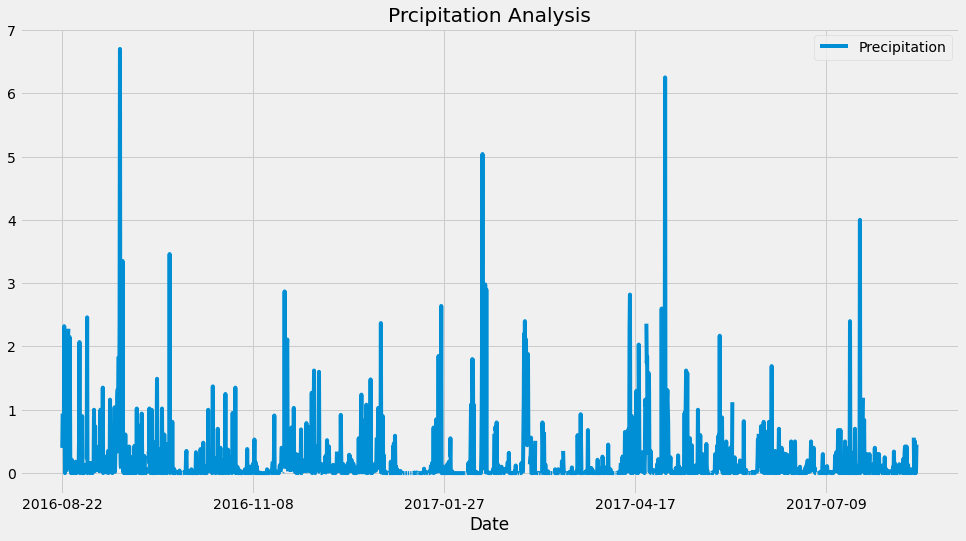

In [76]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Prcipitation Analysis", figsize=(15, 8))
plt.legend(loc="upper right")
plt.savefig("C:/Users/abrow/Desktop/EMERSON_BOOTCAMP/BOOTCAMP_AMB/Homeworks/HW8_11-20-21_SQL__Alchemy_Homework/SQLAlchemy-Challenge/Images/precipitation_analysis.png")
plt.show()

In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [80]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [87]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations=(session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs=[measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]

most_active=(session.query(*tobs).filter(measurement.station=='USC00519281').all())
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [92]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_12mos=(session.query(measurement.date,(measurement.tobs)).filter(func.strftime(measurement.date)>one_year).filter(measurement.station=='USC00519281').all())

In [99]:
# making a dataframe out of the query results
tobs_df=pd.DataFrame(tobs_12mos)
tobs_df.columns=['Date', 'Tobs']
tobs_df.set_index('Date',inplace=True)
tobs_df

,Tobs
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


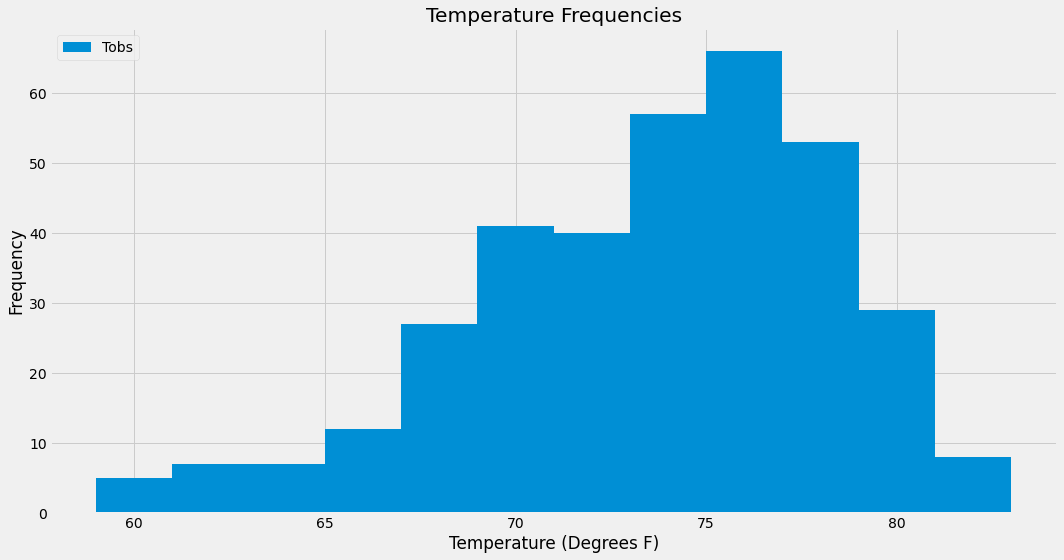

In [100]:
# Making a histogram
tobs_df.plot.hist(bins=12, title="Temperature Frequencies", figsize=(15,8))
plt.xlabel("Temperature (Degrees F)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("C:/Users/abrow/Desktop/EMERSON_BOOTCAMP/BOOTCAMP_AMB/Homeworks/HW8_11-20-21_SQL__Alchemy_Homework/SQLAlchemy-Challenge/Images/temperature_frequency.png")
plt.show()

# Close session

In [101]:
# Close Session
session.close()